# 凸計画とKKT条件
## 前準備
この演習では、Python 用凸計画パッケージ`cvxopt` を使用します。
事前に、
```shell
% pip install cvxopt
```
または、
```shell
% conda install cvxopt
```
コマンドを実行し、`cvxopt` をインストールしてから演習を開始して下さい。

## 凸２次計画問題
ここでは、以下の凸２次計画問題を解くことを考えましょう。
\begin{align*}
\text{目的関数: }
& f(x):=\frac{1}{2} x^\top Qx+c\top x\to\text{最小}\\
\text{制約条件: }
& Ax\le b
\end{align*}
ただし、$Q\in\mathbb{R}^{n\times n}$ は半正定値対称行列、$c\in\mathbb{R}^2$、また$A\in\mathbb{R}^{m\times n}$, $b\in\mathbb{R}^m$ とします。
ここでは、$n:=2$ として、下記のパラメータを用意しましょう。

In [1]:
from cvxopt import matrix

Q = matrix([10., 21., 21., 97.], (2, 2))
c = matrix([-2, -1], (2, 1))
A = matrix([5., 8., 3., 8.], (2, 2))
b = matrix([0., 5.], (2, 1))

## `cvxopt` を用いた非線形凸計画
`cvxopt` には、非線形凸計画ソルバ`cvxopt.solvers.cp` が含まれています。
これを用いると、例えば次のような非線形計画問題、
\begin{align*}
\text{目的関数: }
& f(x)\to\text{最小}\\
\text{制約条件: }
& Ax\le b
\end{align*}
を解くことができます。
ここで、$f:\mathbb{R}^n\to\mathbb{R}$ は2回連続的微分可能な凸関数、$A\in\mathbb{R}^{n\times n}$, $b\in\mathbb{R}^n$ とします。
非線形凸計画ソルバ`cvxopt.solvers.cp` は、次の形式で呼び出すことで、与えられた最適化問題を解きます。
(詳細は、[CVXOPT User's Guide](https://cvxopt.org/userguide/solvers.html) を参照のこと。)
```python
def F(x=None, z=None):
    if x is None: return 0, (初期点)
    func = (x での目的関数値)
    grad = (x での勾配)
    if z is None: return func, grad
    hess = z * (x でのヘッセ行列)
    return func, grad, hess
(結果) = solvers.cp(F, A, b)
```
では、早速先程の凸２次計画問題を解いてみましょう。

In [2]:
from cvxopt import matrix, solvers

def F(x=None, z=None):
    if x is None: return 0, matrix(0., (2, 1))
    func = x.T * Q * x / 2. + c.T * x
    grad = (Q * x + c).T
    if z is None: return func, grad
    hess = z * Q
    return func, grad, hess
solution = solvers.cp(F, A, b)
solution['x'][0], solution['x'][1]

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -5.0000e+00  3e+00  1e+00  1e+00
 1: -2.0577e-01  6.3050e-01  8e-01  6e-01  6e-01
 2:  4.1537e-02 -1.4419e-01  3e-01  2e-02  4e-17
 3: -2.1284e-03 -8.4639e-03  1e-02  1e-03  5e-17
 4: -2.9605e-04 -3.9138e-04  2e-04  1e-05  9e-17
 5: -2.6556e-04 -2.6652e-04  2e-06  2e-07  6e-17
 6: -2.6526e-04 -2.6526e-04  2e-08  2e-09  7e-17
Optimal solution found.


(0.0015915117251406369, -0.0026525199525655966)

計算結果は、不等式制約に対するスラック変数$s_l(\in\mathbb{R}^m)\ge 0$と、パラメータ$z_l(\in\mathbb{R}^m)\ge 0$ について、以下のKKT 条件を(近似的に)満たすよう求められます。
\begin{align*}
\nabla f(x)+A^\top z_l=0,\\
Ax+s_l=b,\\
s_l^\top z_l=0.
\end{align*}
これをそれぞれ確認してみましょう。

In [3]:
func, grad = F(solution['x'])
print(grad.T + A.T * solution['zl'])

[ 1.33e-15]
[ 8.88e-16]



In [4]:
print('Ax+s_l=')
print(A * solution['x'] + solution['sl'])
print('b=')
print(b)

Ax+s_l=
[-4.98e-19]
[ 5.00e+00]

b=
[ 0.00e+00]
[ 5.00e+00]



In [5]:
print(solution['sl'].T * solution['zl'])

[ 1.32e-08]



## KKT条件とベクトルの均衡
それでは、KKT 条件が表す均衡関係を図示してみましょう。

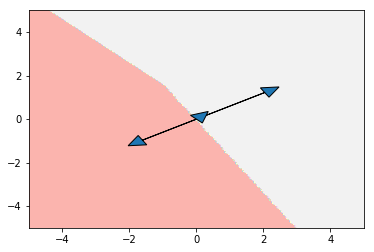

In [6]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot

A, b = np.array(A), np.array(b).reshape(len(b))
zl = np.array(solution['zl']).reshape(len(solution['zl']))

X, Y = np.meshgrid(np.linspace(-5, 5, 150), np.linspace(-5, 5, 150))
Z = np.array([1 - 2 * (np.dot(A, row) - b <= 0).all() for row in np.vstack([X.ravel(), Y.ravel()]).T]).reshape(X.shape)
pyplot.contourf(X, Y, Z, cmap='Pastel1')
pyplot.arrow(solution['x'][0], solution['x'][1], grad[0], grad[1], length_includes_head=True, head_width=0.5, head_length=0.5)
for i, z in enumerate(zl):
    pyplot.arrow(solution['x'][0], solution['x'][1], A[i, 0] * z, A[i, 1] * z, head_width=0.5, head_length=0.5)

目的関数の勾配(赤色方向の領域へのベクトル) は、制約式の勾配(緑色方向の領域へのベクトル) と釣り合っていることが分かります。
特に、有効な(解が境界(右下の直線)上にある)制約のベクトルは、そのノルムを持ち、関係のない(解が境界(左上の直線)上にない)制約のベクトルは、ノルム0 となっていることが分かります。